## 1. 필요한 모듈 임포트

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
BATCH_SIZE =
EPOCHS =
DEVICE = 'cuda'
LR =

## 2. Load dataset
- 데이터세트 다운로드
- 데이터세트 정보
- 예시

100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


Extracting ../data/CIFAR10/cifar-10-python.tar.gz to ../data/CIFAR10
Files already downloaded and verified
X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


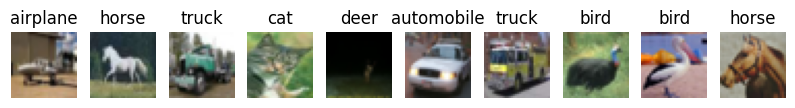

In [ ]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB 정규화
])

# CIFAR-10 데이터셋 로드
train_dataset = datasets.CIFAR10(root="../data/CIFAR10",
                                 train=True,
                                 download=True,
                                 transform=transform)

test_dataset = datasets.CIFAR10(root="../data/CIFAR10",
                                train=False,
                                download=True,
                                transform=transform)

# DataLoader 설정
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

# 배치 확인
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

# CIFAR-10 클래스 이름
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# CIFAR-10 시각화
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))  # 10개 plot하기 위한 figure 크기 설정

for i in range(10):
    plt.subplot(1, 10, i + 1)  # plot.subplot(rows, columns, index)
    plt.axis('off')
    # 이미지의 채널 순서를 numpy로 변환
    plt.imshow(X_train[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # 정규화 복원
    plt.title(classes[y_train[i].item()])

## 3-1. 인공지능 신경망 (MLP)


```
nn.Linear(in_channels, out_channels)
```


```
F.sigmoid()
F.relu()
```


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32*32*3,    ) # 32*32*3 고정
        self.fc2 = nn.Linear(   ,    )
        self.fc3 = nn.Linear(   , 10) # 10 고정

    def forward(self,x):
        x = x.view(-1, 32*32*3)
        x = self.fc1(x)
        x = F.   (x)
        x = self.fc2(x)
        x = F.   (x)
        x = self.fc3(x)
        return x

model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.5)
criterion = nn.CrossEntropyLoss()

## 3-2. 인공지능 신경망(CNN)

```
# 가로 세로 크기 유지
nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1, stride = 1)
nn.Conv2d(in_channels, out_channels, kernel_size = 5, padding = 2, stride = 1)
nn.Conv2d(in_channels, out_channels, kernel_size=7, padding=3, stride=1)
```

```
# 가로 세로 크기 반으로 줄어듦
ex : (32, 32) -> (16, 16)
nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2)
nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2, stride=2)
nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=2)
```

```
# 가로 세로 크기 줄이는 방법 (Pooling)
# 크기가 1/s 배 됨
# Ex : s = 2이면 (32, 32) -> (16, 16)
nn.MaxPool2d(kernel_size=s, stride=s)
nn.AvgPool2d(kernel_size=s, stride=s)
```

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional Block 1: Conv2d -> ReLU -> BatchNorm
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 32 -> 32
        self.bn1 = nn.BatchNorm2d(32)








        self.fc2 = nn.Linear(   , 10)  # 10 (class labels) 고정


    def forward(self, x):
        # Convolutional Block 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)


        x = self.fc2(x)  # Output layer (no activation for logits)
        return x


model = CNN().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.5)
criterion = nn.CrossEntropyLoss()

## 4. 학습 / 검증 함수

In [ ]:
# 학습 기록 저장을 위한 리스트
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train(model, train_loader, optimizer, epoch, log_interval=10):
    model.train()
    correct = 0
    running_loss = 0
    total = 0

    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total += label.size(0)
        prediction = output.max(1, keepdim=True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()

        if batch_idx % log_interval == 0:
            print("Train epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

    # 에포크 단위로 평균 손실 및 정확도 계산
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)


def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    return test_loss, accuracy



## 5. 학습 반복문

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(
        epoch, test_loss, test_accuracy))

Train epoch: 1 [0/50000 (0%)]	Train Loss: 2.326327
Train epoch: 1 [6400/50000 (13%)]	Train Loss: 1.837764
Train epoch: 1 [12800/50000 (26%)]	Train Loss: 1.629214
Train epoch: 1 [19200/50000 (38%)]	Train Loss: 1.908087
Train epoch: 1 [25600/50000 (51%)]	Train Loss: 1.660234
Train epoch: 1 [32000/50000 (64%)]	Train Loss: 1.289203
Train epoch: 1 [38400/50000 (77%)]	Train Loss: 1.571358
Train epoch: 1 [44800/50000 (90%)]	Train Loss: 1.209002

[EPOCH: 1], 	Test Loss: 1.1989, 	Test Accuracy: 57.73 %

Train epoch: 2 [0/50000 (0%)]	Train Loss: 1.271283
Train epoch: 2 [6400/50000 (13%)]	Train Loss: 1.181402
Train epoch: 2 [12800/50000 (26%)]	Train Loss: 1.458784
Train epoch: 2 [19200/50000 (38%)]	Train Loss: 1.052333
Train epoch: 2 [25600/50000 (51%)]	Train Loss: 1.068532
Train epoch: 2 [32000/50000 (64%)]	Train Loss: 1.139153
Train epoch: 2 [38400/50000 (77%)]	Train Loss: 1.379879
Train epoch: 2 [44800/50000 (90%)]	Train Loss: 1.296191

[EPOCH: 2], 	Test Loss: 1.0705, 	Test Accuracy: 62.04 %



## 6. 시각화

In [ ]:

# 학습 결과 시각화
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 6))

# Train/Test Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Train/Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()